In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
import pickle
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import collections  as mc

import cartopy.crs as ccrs
from feems import SpatialGraph, Viz
from feems.viz import project_coords
from feems.spatial_graph import query_node_attributes
from feems.cross_validation import train_test_split

In [2]:
prefix = 'wolves/wolvesadmix'
grid = 100

# todo add projection values to snakemake config
projection = ccrs.EquidistantConic(central_longitude=-108.842926, central_latitude=66.037547)

In [3]:
grid_path = '../data/grids/grid_{grid}.shp'.format(grid=grid)
data_path = '../data/{prefix}'.format(prefix=prefix)

translated = False
output = '../output/{prefix}/feems/grid_{grid}/sp_graph.pkl'.format(prefix=prefix, grid=grid)

In [4]:
result_path_regex = lambda method, runid: \
    '../output/{prefix}/{method}/grid_{grid}/leave_node_out/{runid}/*'.format(
    prefix=prefix, method=method, grid=grid, runid=runid)

result_paths = lambda method, runid: np.sort(glob(
    '../output/{prefix}/{method}/grid_{grid}/leave_node_out/{runid}/*'.format(
    prefix=prefix, method=method, grid=grid, runid=runid)
))

In [5]:
sp_graph_path = '../output/{prefix}/feems/grid_{grid}/sp_graph.pkl'.format(prefix=prefix, grid=grid)
sp_graph = pickle.load(open(sp_graph_path, 'rb'))

coord_path = '../data/{prefix}.coord'.format(prefix=prefix)
coord = pd.read_csv(coord_path, sep='\s', header=None);

lno_coord_paths = np.sort(glob('../output/popres/c1global1nfd/feems/grid_250/leave_node_out/coord/*'))
lno_coords = [pd.read_csv(f, sep='\t', header=None) for f in lno_coord_paths]

lno_coord_paths = np.sort(glob('../output/{prefix}/locator/grid_{grid}/leave_node_out/coord/*'.format(
    prefix=prefix, grid=grid)))
lno_coords = [pd.read_csv(f, sep='\t', header=None) for f in lno_coord_paths]

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [6]:
def draw_prediction(self, true_coord, pred_coord):
    # draw line segments
    lines = [(true_coord[i], pred_coord[i]) for i in range(pred_coord.shape[0])]
    lc = mc.LineCollection(lines, colors='k', linewidths=0.5)
    self.ax.add_collection(lc)

    # draw true coordinates
    self.ax.scatter(
        true_coord[:, 0],
        true_coord[:, 1],
        edgecolors="black",
        s=1,
        alpha=self.obs_node_alpha,
        color=self.obs_node_color,
        zorder=self.obs_node_zorder,
    )
    
    # draw predicted coordinates
    self.ax.scatter(
        pred_coord[:, 0],
        pred_coord[:, 1],
        edgecolors="red",
        color='red',
        s=1,
        alpha=self.obs_node_alpha,
        zorder=self.obs_node_zorder,
    )

def plot_predictions(true_coord, pred_coord, projection, sp_graph):
    fig = plt.figure(dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=projection)  
    v = Viz(ax, sp_graph, projection=projection, edge_width=.5, 
            edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
            obs_node_size=7.5, sample_pt_color="black", 
            cbar_font_size=10)
    v.draw_map()
    v.draw_edges(use_weights=True)
    v.draw_edge_colorbar()
    
    projected_true_coord = project_coords(true_coord, v.proj)
    projected_pred_coord = project_coords(pred_coord, v.proj)
    draw_prediction(v, projected_true_coord, projected_pred_coord)
    return v

In [7]:
distances = {}

def comp_dist(a, b):
    return np.sqrt(((a - b)**2).sum(1))

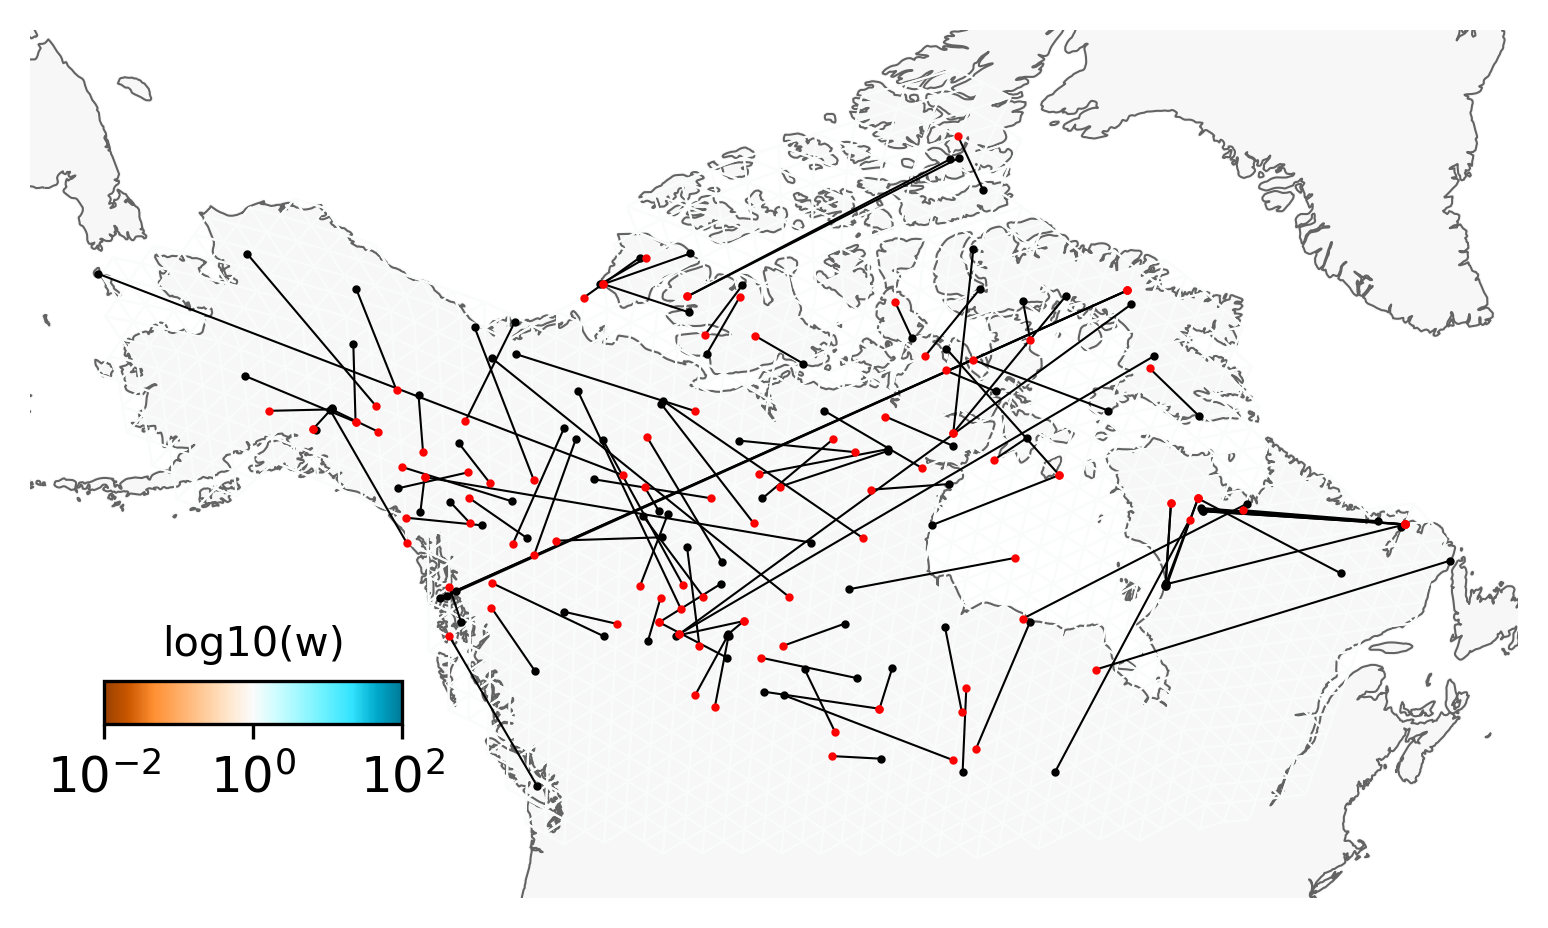

In [8]:
method = 'feems_point_noreg'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

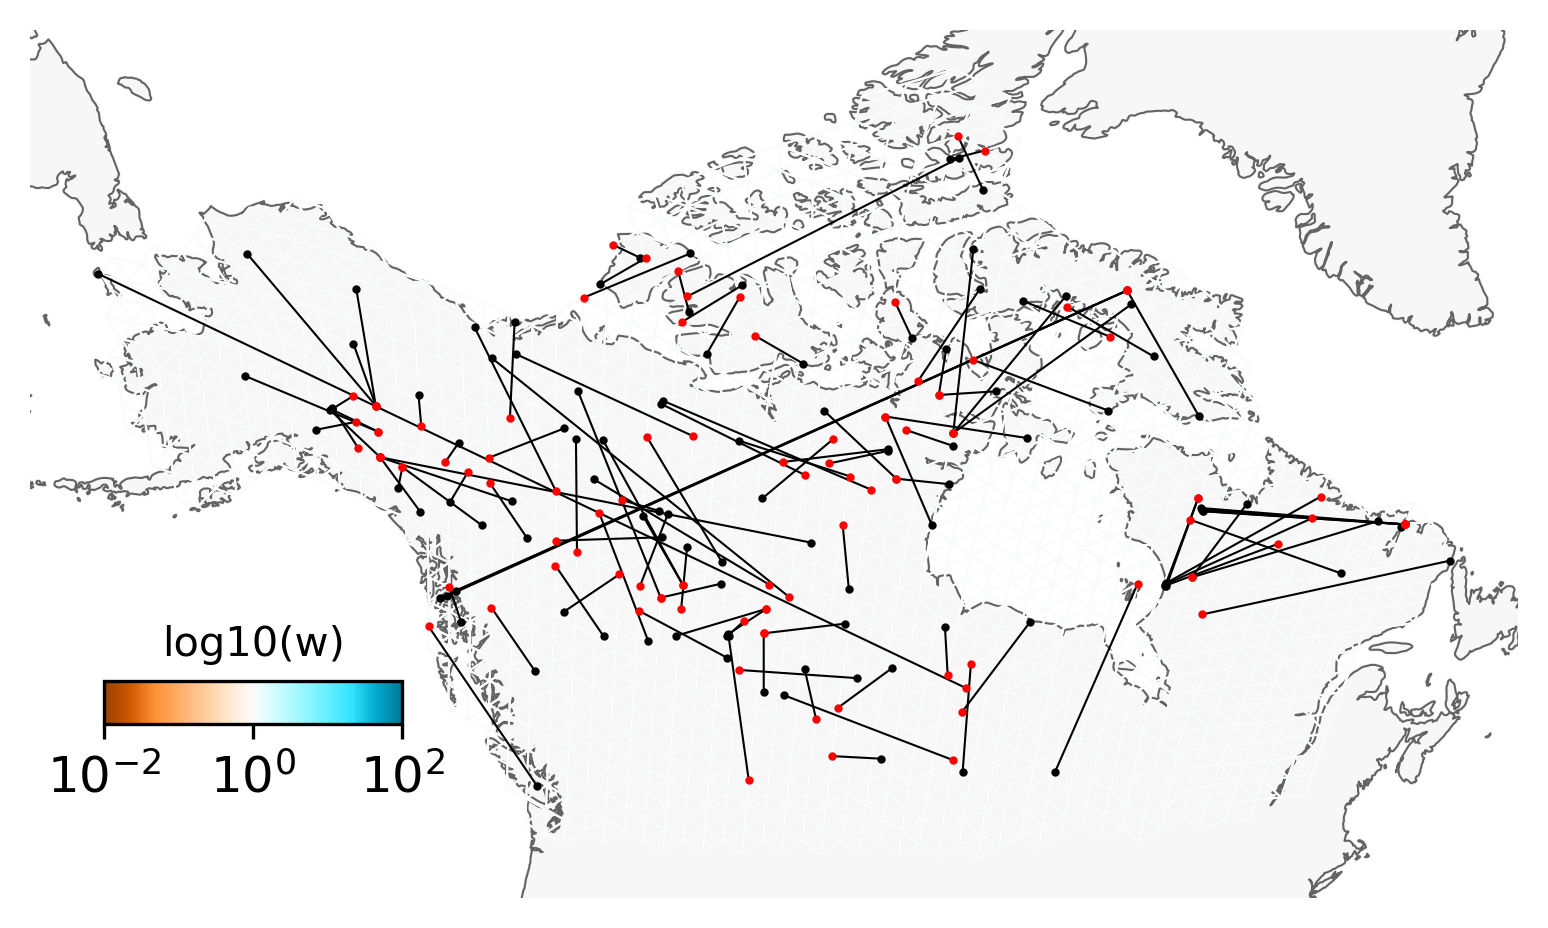

In [9]:
method = 'ibd_point_noreg'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

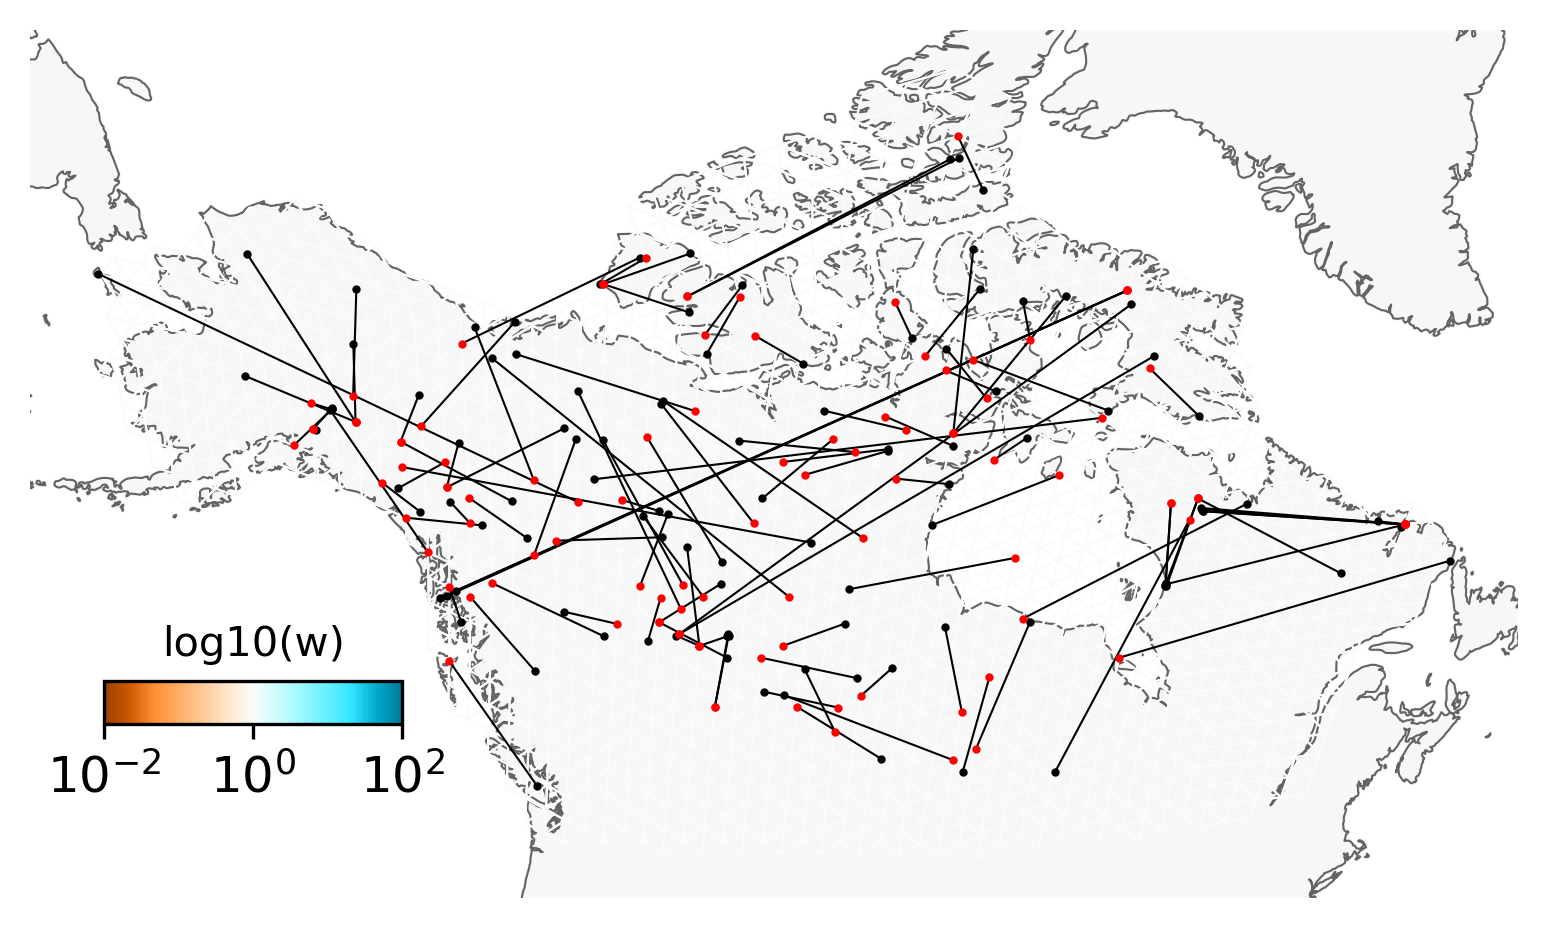

In [10]:
method = 'feems_point_alpha-0.1'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

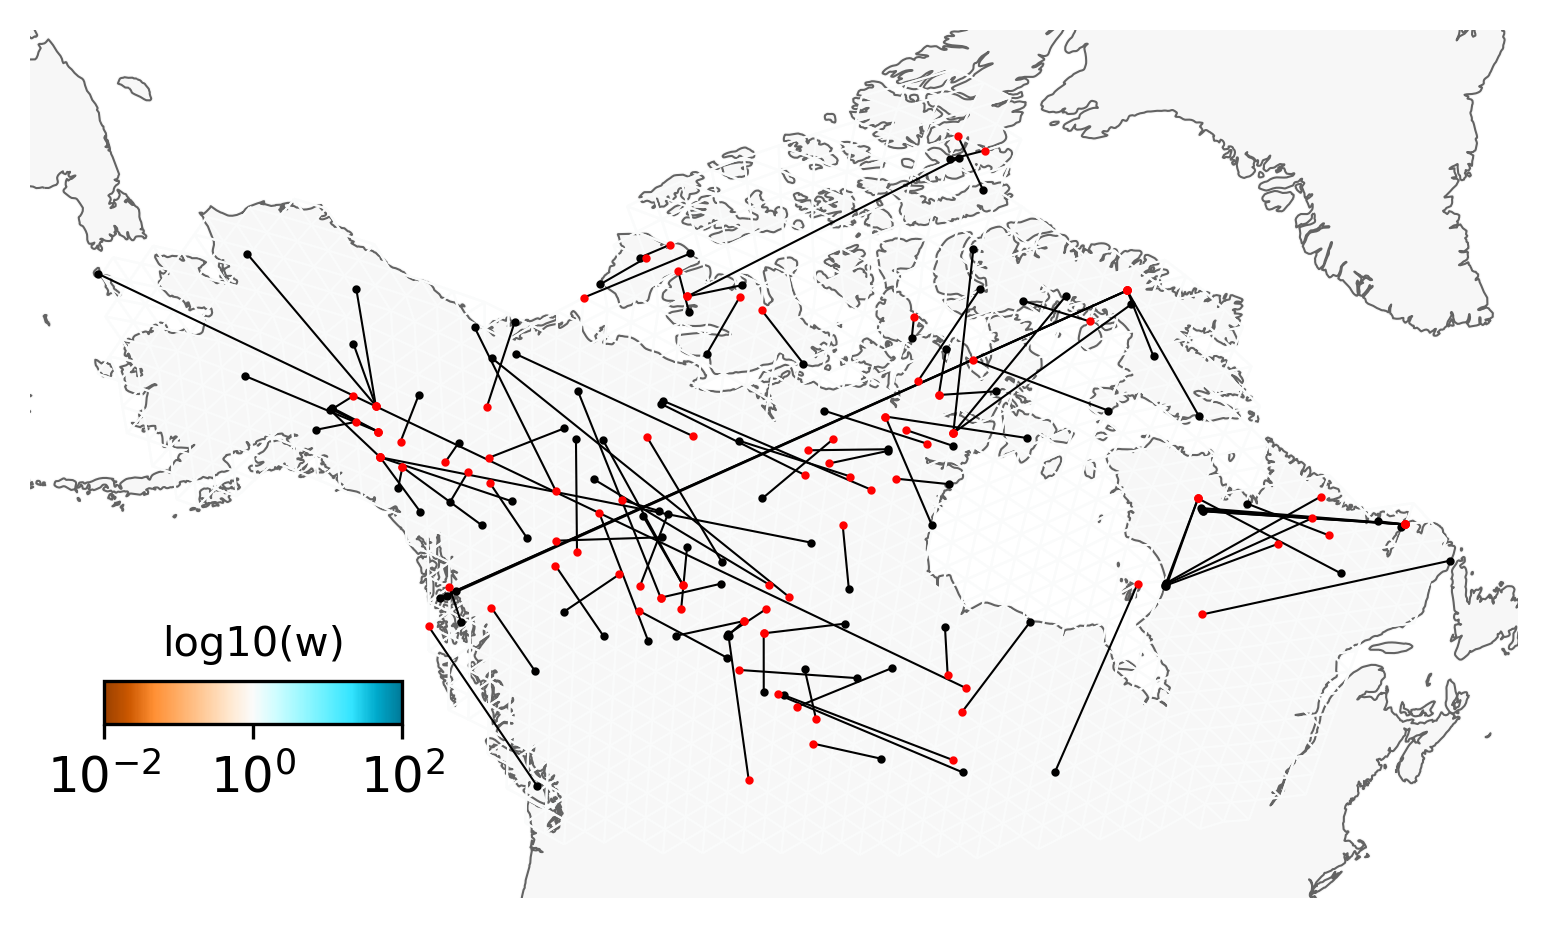

In [11]:
method = 'ibd_point_alpha-0.1'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

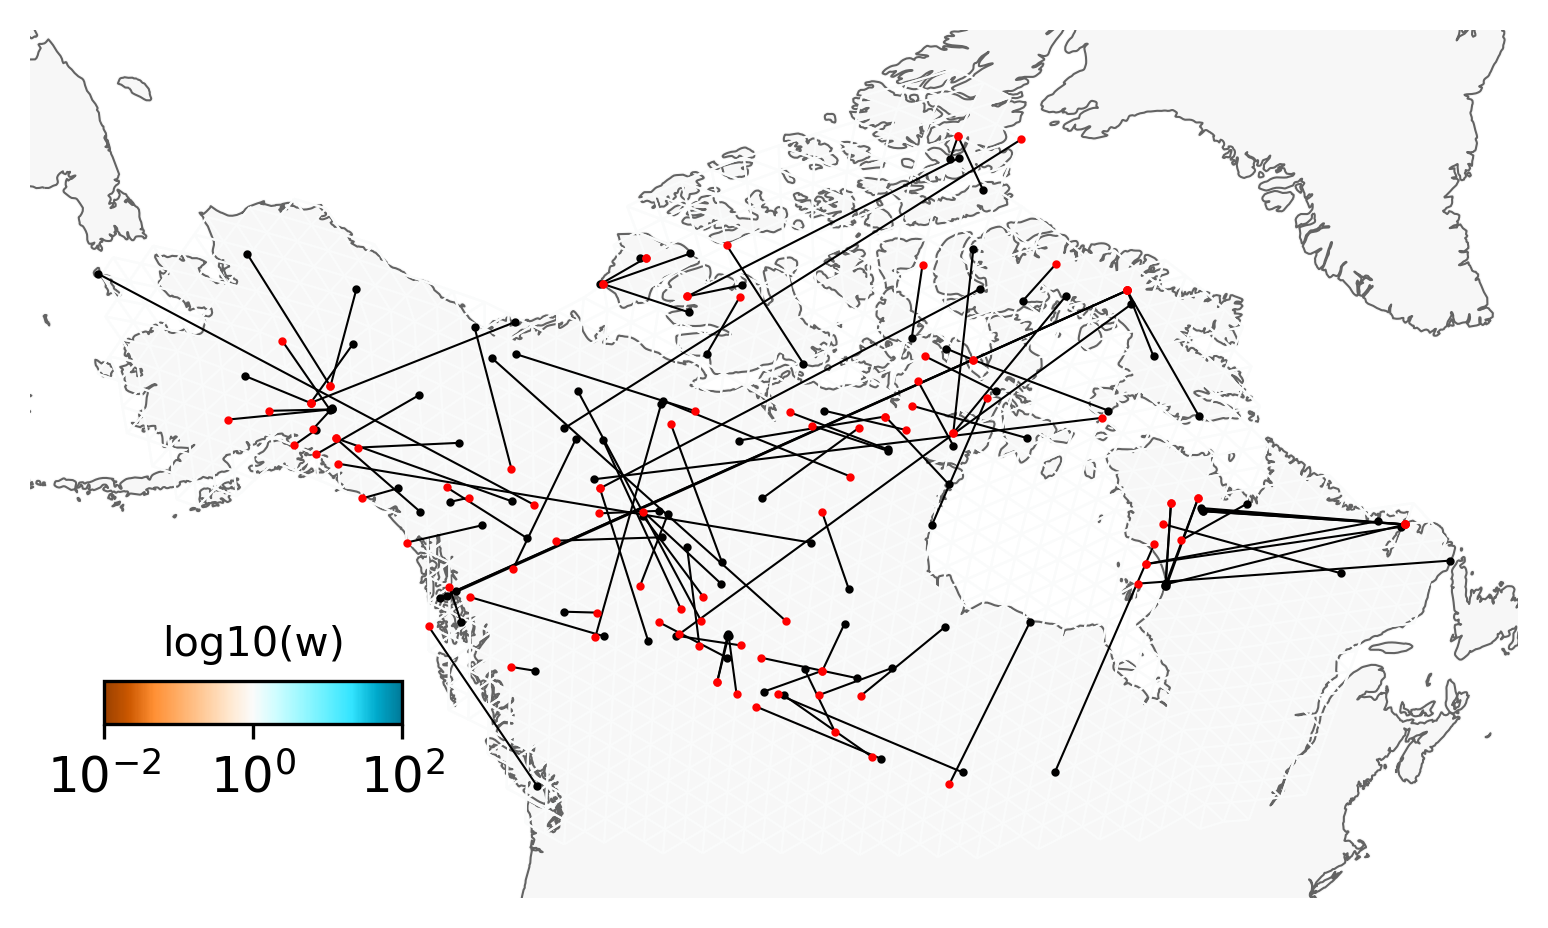

In [12]:
method = 'feems_point_alpha-0.5'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

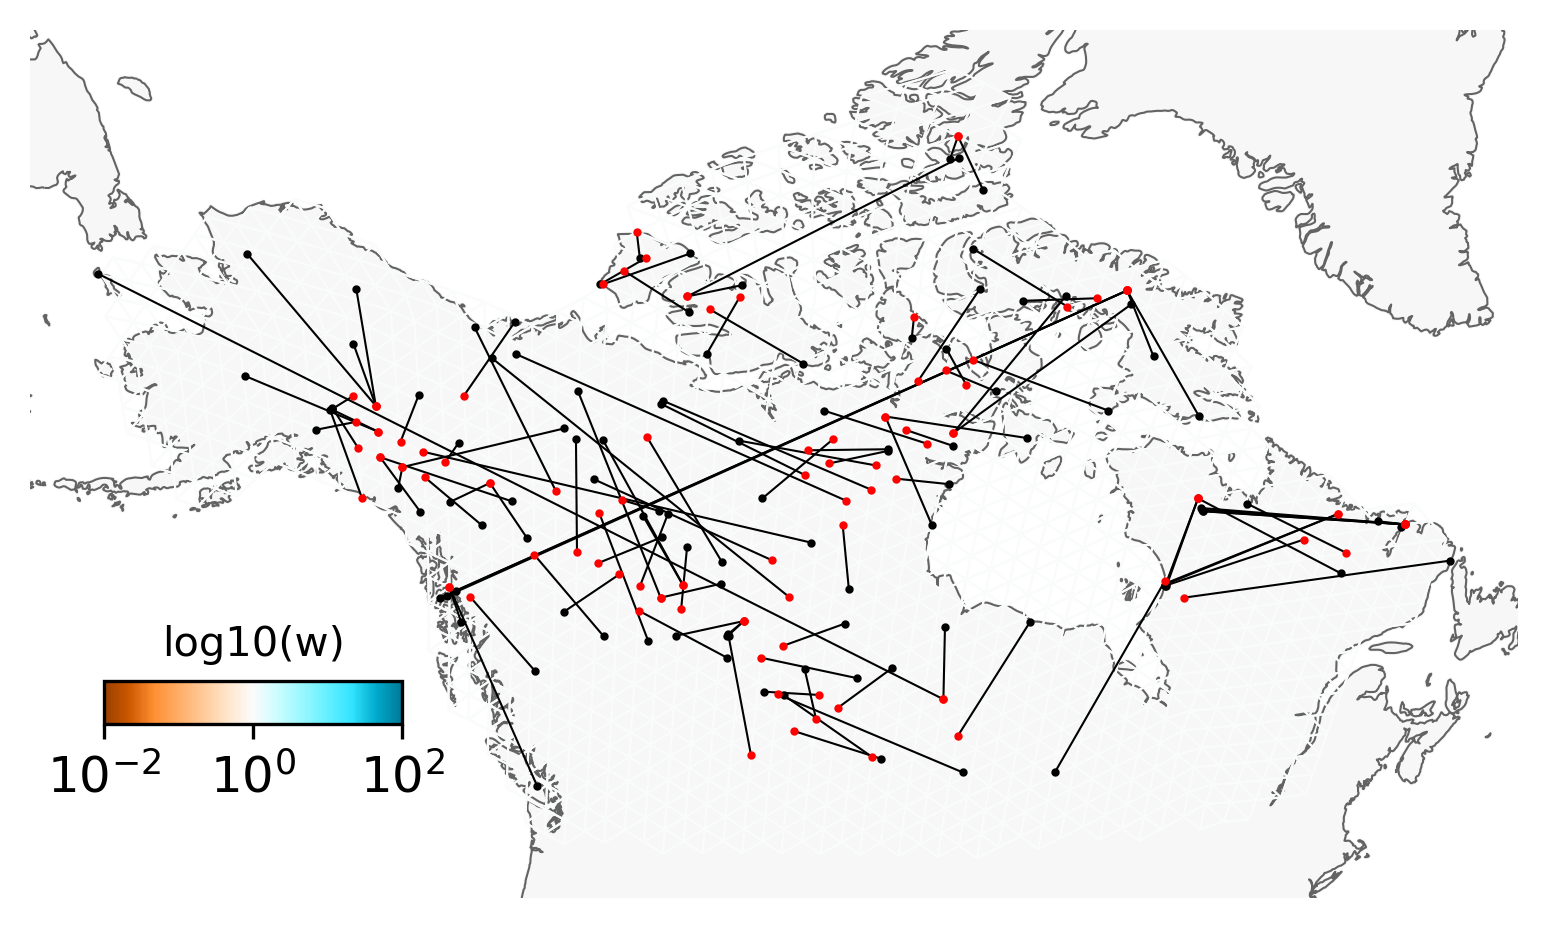

In [13]:
method = 'ibd_point_alpha-0.5'
paths = result_paths('feems', method)
results = [pickle.load(open(f, 'rb')) for f in paths];

pred_coord = []
true_coord = []
for r in results:
    pred_idx = r['pred_idx']
    pred_coord.append(r['map_coord'][pred_idx])
    true_coord.append(coord.values[pred_idx])

true_coord = np.concatenate(true_coord)
pred_coord = np.concatenate(pred_coord)


distances[method] = comp_dist(true_coord, pred_coord)
plt.show(plot_predictions(true_coord, pred_coord, projection, sp_graph))

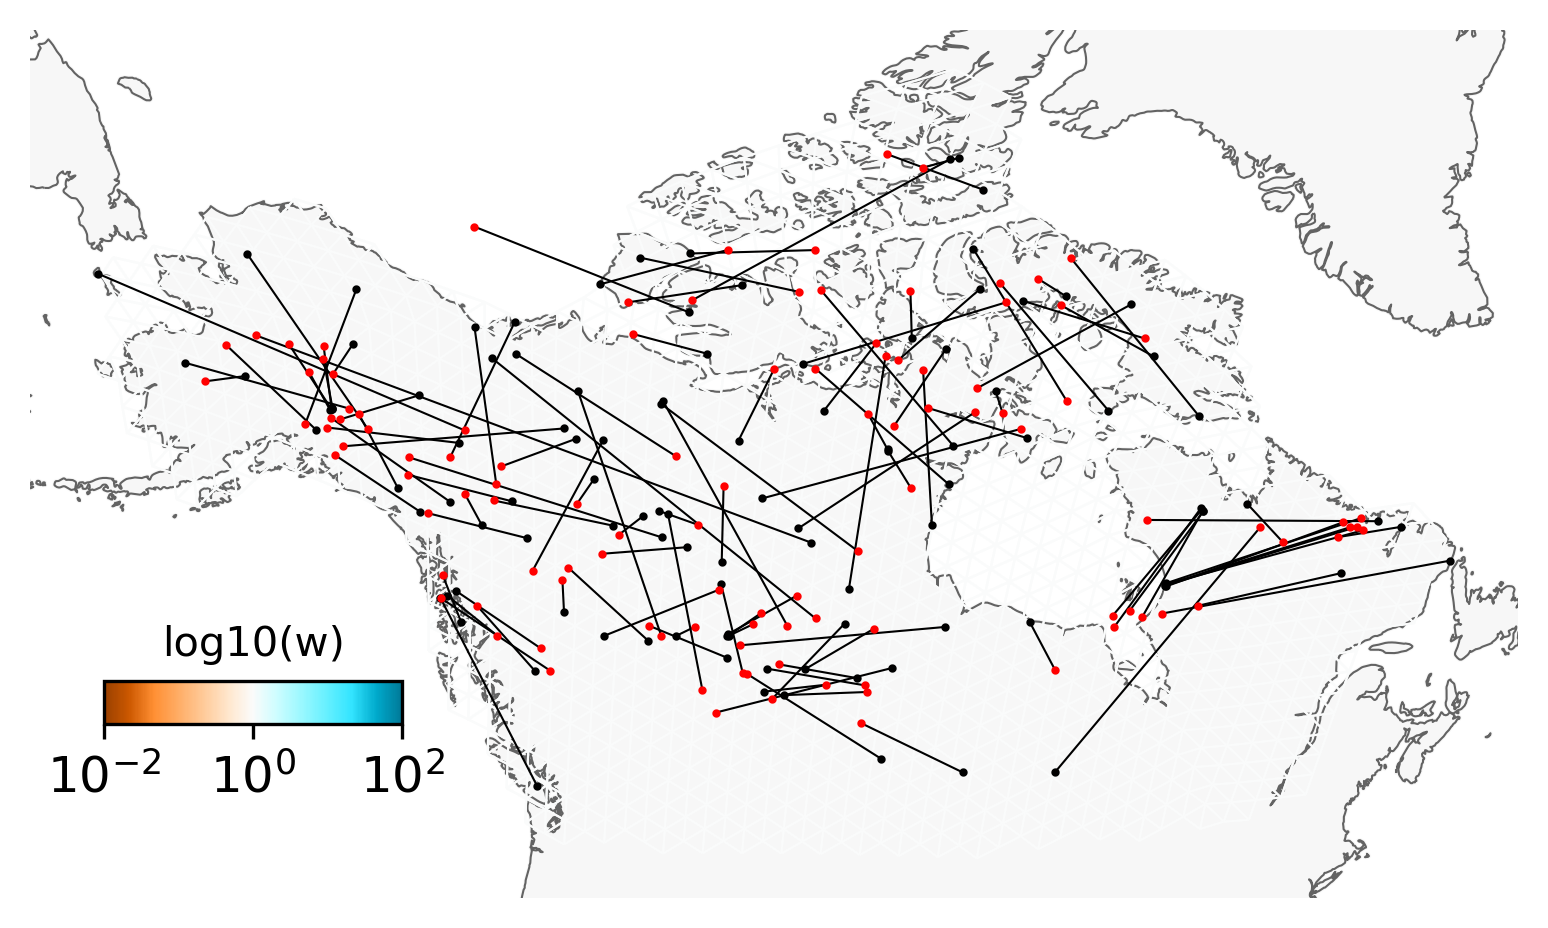

In [14]:
locator_paths = result_paths('locator', 'fit')
locator_paths = [l for l in locator_paths if 'predloc' in l]
locator_results = pd.concat([pd.read_csv(f) for f in locator_paths])
locator_results = locator_results.set_index('sampleID').sort_index()

sampleId = pd.read_csv('../output/{prefix}/locator/grid_{grid}/leave_node_out/coord/000.coord'.format(
    prefix=prefix, grid=grid), sep='\t').sampleID
coord.index = sampleId
coord_sorted = coord.sort_index()


distances['locator'] = comp_dist(coord_sorted.loc[locator_results.index].values, locator_results.values)
plt.show(plot_predictions(coord_sorted.loc[locator_results.index].values,
                          locator_results.values, projection, sp_graph))

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


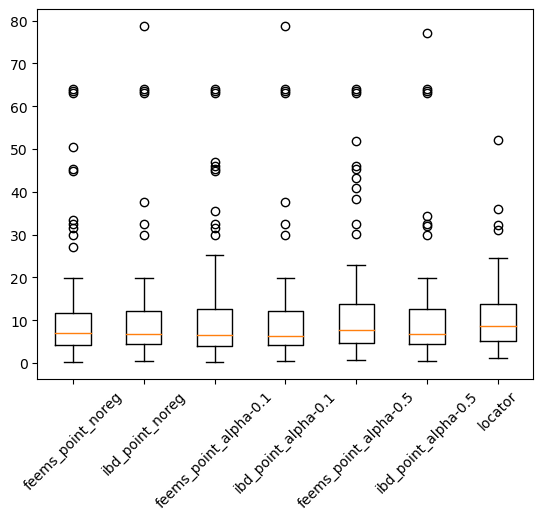

In [15]:
# Python 3.5+
labels, data = [*zip(*distances.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = distances.keys(), distances.values()

fig, ax = plt.subplots(1)

ax.boxplot(data)
ax.set_xticklabels(labels, rotation = 45)
plt.show()

/project2/jnovembre/ktayeb/spatial_prediction/spatial_prediction_workflow/.snakemake/conda/2c7cf4bb1773d38c102bc0689cd06b72/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


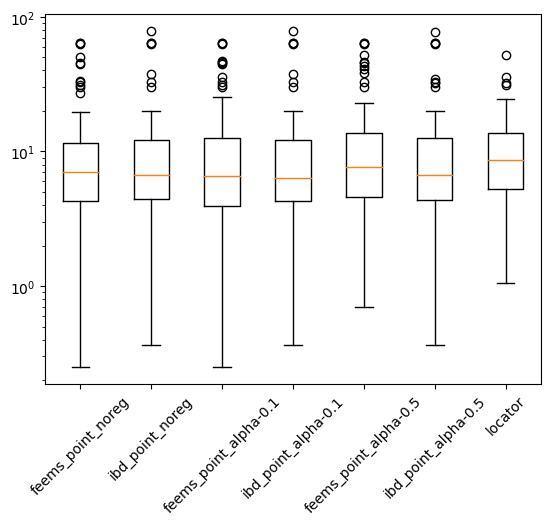

In [16]:
# Python 3.5+
labels, data = [*zip(*distances.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = distances.keys(), distances.values()

fig, ax = plt.subplots(1)

ax.boxplot(data)
ax.set_xticklabels(labels, rotation = 45)
ax.set_yscale('log', basey=10)

plt.show()